In [1]:
using InstantiateFromURL
activate_github("QuantEcon/QuantEconLecturePackages", tag="v0.3.1")
using QuantEcon
using LinearAlgebra, Statistics, Compat
using LaTeXStrings
using Plots
using Parameters

┌ Info: Recompiling stale cache file /home/jupyter/.julia/compiled/v1.0/QuantEcon/V0Mv9.ji for QuantEcon [fcd29c91-0bd7-5a09-975d-7ac3f643a60c]
└ @ Base loading.jl:1187


  1.481365 seconds (15.29 M allocations: 1.361 GiB, 11.29% gc time)
iter = 298


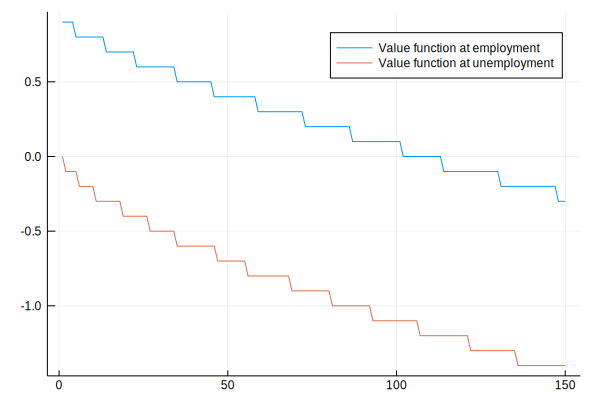

In [12]:
#------Household Problem
u(c,σ)= (c^(1-σ))/(1-σ) 
r=0.00
AiyagariModel = @with_kw (β=0.96, # discount rate
    σ=1.1,
    α=0.33, 
    A=1,
    δ=0.05,
    z=[0.1; 1.0],
    p=[0.9 0.1; 0.1 0.9],
    a_min=1e-10,
    a_max=15,
    a_size=150) 
param = AiyagariModel()
#---function  calculate optimal policy function and the value function
function hh_policy(param,r;max_iter=500)
@unpack β,σ,α,A ,δ,z,p, a_min,a_max,a_size=param
a_vals = range(a_min, a_max,  length=a_size) 

w=A*(1-α)*((A*α/(r+δ))^α/(1-α)) 
v_new=zeros(length(a_vals))
v=zeros(length(a_vals),length(z))
v_old=zeros(length(a_vals),length(z))
a_prime=zeros(length(a_vals),length(z))
error=1
iter=0 
   #---iteration
   while error>1e-3 && iter<max_iter
for i in eachindex(a_vals)          # for a
    for j in eachindex(z)           # for z
        for k in eachindex(a_vals)  # for a'
            c=(1+r)*a_vals[i]+w*z[j]-a_vals[k]
            if c>0
            v_new[k]=u(c,σ)+β*(p[j,:]'*v_old[k,:])
            else
              v_new[k]=-Inf     
            end
                
        end
      
              v[i,j]  =findmax(v_new)[1]
               a_prime[i,j]= findmax(v_new)[2]  # gives integer
   end
end
        error=norm((v-v_old)) 
        v_old=copy(v)
        iter=iter+1 
       
    end  
    
    return v_old,a_prime,iter
end
@time   v_old,a_prime,iter= hh_policy(param,r)

    @show iter
    #---function  calculate saving in each state
    #we do not need this function to iterate every time
function asset_change(a_prime,param)
   @unpack β,σ,α,A ,δ,z,p, a_min,a_max,a_size=param
    a_vals = range(a_min, a_max,  length=a_size) 
    current_asset=zeros(length(a_vals),length(z))
    new_saving   =zeros(length(a_vals),length(z))
    for j in eachindex(z)
    for i in eachindex(a_vals)
    current_asset[i,j]=i
    end
    end
    
    for j in eachindex(z)
    for i in eachindex(a_vals)
    current_asset[i,j]=i
    end
    end
  return new_saving=(a_prime.-current_asset)*(a_max-a_min)/a_size
        
    end
   new_saving=asset_change(a_prime,param)
    plot(new_saving[:,2],label = "Value function at employment")
    plot!(new_saving[:,1],label = "Value function at unemployment")

In [19]:
a=[1 22 34]
a_v=[1 2]
a[a_v]

1×2 Array{Int64,2}:
 1  22

In [3]:
#---finding stationary distribution   

function stationary_dist(a_prime,param;max_iter=500)
 @unpack β,σ,α,A ,δ,z,p, a_min,a_max,a_size=param
a_vals = range(a_min, a_max,  length=a_size) 
λ=ones(length(a_vals),length(z))/(length(a_vals)*length(z))
λ_new=ones(length(a_vals),length(z))
iter=0
error=1
    while iter<max_iter && error>1e-10 
    for j in 1: length(z)   
    for k in eachindex(a_vals)
           λ_new[k,j]=copy(p[1,j]*sum(λ[i,1]*(a_prime[i,2]==k) for i in eachindex(a_vals)) +p[2,j]*sum(λ[i,2]*(a_prime[i,2]==k) for i in eachindex(a_vals))) 
    end
    end
    error=norm(λ_new-λ) 
    iter=iter+1
    λ.=λ_new    
    end
    λ_s=sum(λ)
    n_λ=λ./λ_s
    return iter,error,λ_s,n_λ,a_vals 
end
@time  iter_s,error_s,λ_s,λ,a_vals =stationary_dist(a_prime,param)
#we get a_vals   for the simplicity of next part
        

    

  0.323037 seconds (742.91 k allocations: 35.127 MiB, 2.76% gc time)


(38, 0.0, 1.0000000000000004, [0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0], 1.0e-10:0.1677852348986577:25.0)

In [15]:
function station_equi(param,r,max_iter=500)
 @unpack β,σ,α,A ,δ,z,p, a_min,a_max,a_size=param
    iter=0
    er=1.0
    k=0.0
    L=0.0
    #(1-β)/2
    a_vals = range(a_min, a_max, length=a_size) 
    while er>1e-5 && iter<max_iter
   
    v_old,a_prime,iter_h= hh_policy(param,r)
  
    iter_s,error_s,λ_s,λ,a_vals =stationary_dist(a_prime,param)
  
    L=sum((z')*λ')  
    k=sum(a_vals'*λ)
    r_new=α*A*(k^(α-1))*(L^(1-α))-δ
    er=norm(r_new-r)
        r=r_new
        iter=iter+1
    end
    return iter,er,r,L,k,λ,a_prime
end
@time begin
iter,er,r,L,k,λ,a_prime=station_equi(param,0.0)
    end

 10.595762 seconds (106.08 M allocations: 9.473 GiB, 11.77% gc time)


(7, 0.0, -0.002701211217719532, 0.5499999999999999, 9.98993288593944, [0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0], [1.0 10.0; 1.0 11.0; … ; 135.0 146.0; 136.0 147.0])

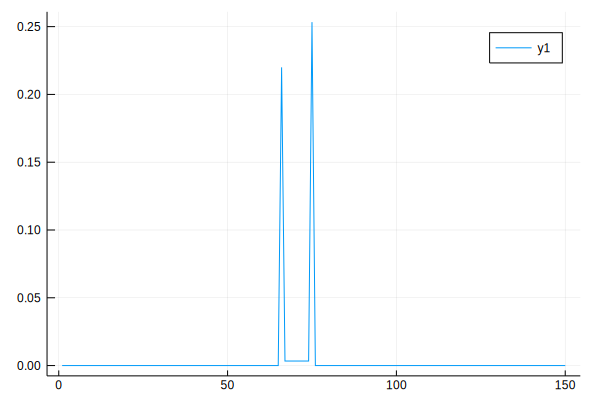

In [18]:
f(a)=a
plot(a_prime[:,2]-f(1:150))
plot(λ[1:150,1])